In [1]:
import torch
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
feature_maps = []
gradients = []

def forward_hook(module, input, output):
    feature_maps.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# Last convolution layer
target_layer = model.layer4[-1]

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [3]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
import torch.nn.functional as F
import numpy as np

def generate_gradcam(image_path):
    feature_maps.clear()
    gradients.clear()

    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    output = model(input_tensor)
    class_idx = output.argmax()

    model.zero_grad()
    output[0, class_idx].backward()

    grads = gradients[0].mean(dim=[2, 3], keepdim=True)
    fmap = feature_maps[0]

    cam = (grads * fmap).sum(dim=1)
    cam = F.relu(cam)
    cam = cam.squeeze().detach().cpu().numpy()

    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam, img

In [5]:
import cv2
import matplotlib.pyplot as plt

def show_gradcam(image_path):
    cam, img = generate_gradcam(image_path)

    cam = cv2.resize(cam, img.size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = np.array(img)
    overlay = 0.4 * heatmap + 0.6 * img_np

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis("off")
    plt.title("Grad-CAM: Image Regions Influencing Price")
    plt.show()

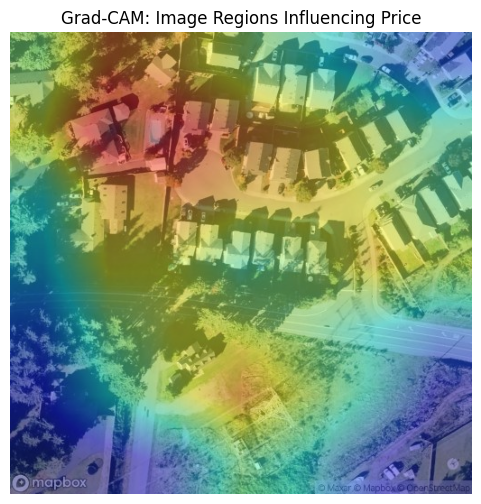

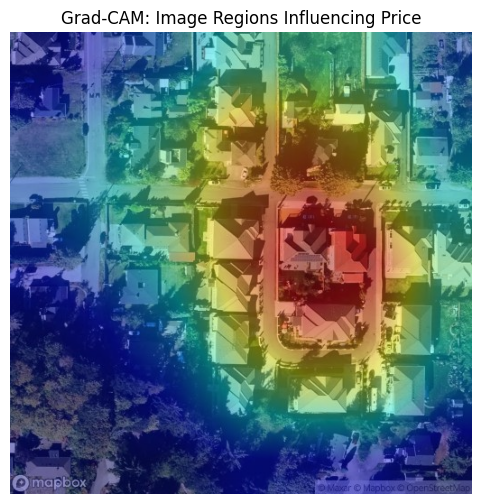

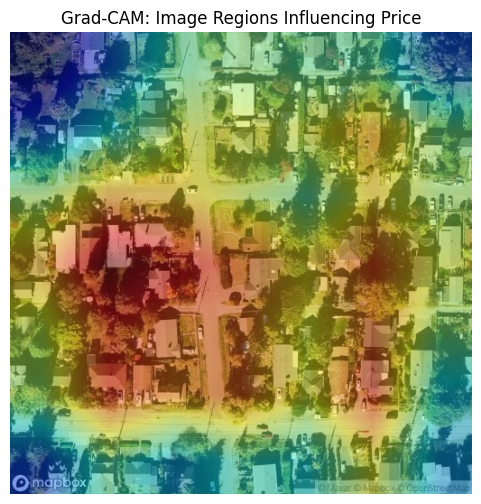

In [8]:
show_gradcam("/content/sample_image1.png")
show_gradcam("/content/sample_image2.png")
show_gradcam("/content/sample_image3.png")